# **BDTs at work: the $\mathrm{\Omega}^{0}_\mathrm{c}$ analysis**

The goal of this tutorial is to train and test a multi-class classification algorithm. The tutorial will focus on the reconstruction of the $\mathrm{\Omega^{0}_{c}}$ baryon ($\mathrm{ssc}$) signal in pp collisions with the data collected by ALICE in the first year of Run 3. 

The $\mathrm{\Omega^{0}_{c}}$ baryon has quite a short lifetime ($c\tau\sim82\mu\mathrm{m}$), so it cannot be detected directly. Therefore, we need to reconstruct it through its decay products. In this tutorial (as well as in the analyses performed by ALICE) we will reconstruct the $\mathrm{\Omega^{0}_{c}}$ baryon through its hadronic decay channel $\mathrm{\Omega^{0}_{c}}$ $\rightarrow$ $\mathrm{\Omega^{-}}$ $\mathrm{\pi^{+}}$. _Machine learning_ (ML) algorithms are used to improve the selection of the interesting signal and the rejection of the uninteresting background (arising from the _combination_ of Omega and pions not produced from $\mathrm{\Omega^0_c}$ decays: the _combinatorial background_).

The $\mathrm{\Omega^{0}_{c}}$ baryons can be categorised as either _prompt_ (i.e. originating from charm quark hadronisation) or _non-prompt_ (i.e. originating from beauty-hadron decays). In this tutorial both these classes are considered. In particular, the ML algorithm is going to classify the $\mathrm{\Omega^{0}_{c}}$ baryon candidates as either prompt, non-prompt, or background.

Prompt candidates are produced very close to the primary vertex, while non-prompt candidates are produced at a displaced vertex (as beauty hadrons have a lifetime of about ($c\tau\sim500\mu\mathrm{m}$), and therefore we can separate the two classes by looking at the distance between the primary and the $\mathrm{\Omega^{0}_{c}}$ baryon decay vertex. More in general, we will be able to separate signal from background exploiting the _displaced topology_ of the $\mathrm{\Omega^{0}_{c}}$ baryon decay.

<img src="img/DsDecaySketch.png" 
     align="center" 
     width="900" />

### **File download**

The first step is to download all the samples we will need for the ML training and test. In Run 3, the tables produced by the analysis workflows in O2Physics can be saved locally as derived data via `TreeCreator` tasks in the form of ROOT `TTrees`. This format is easier to be handled for ML purposes. 

To spare time, the AO2D from hyperloop have been filtered and organised in _.parquet_ files. However, the `TTree` format can be employed as well following the same procedure presented below.

In [1]:
pip list


Package                   Version
------------------------- --------------
alembic                   1.14.1
alibuild                  1.14.6
anyio                     4.8.0
appnope                   0.1.4
argon2-cffi               23.1.0
argon2-cffi-bindings      21.2.0
arrow                     1.3.0
asttokens                 3.0.0
async-lru                 2.0.4
attrs                     25.1.0
awkward                   2.7.4
awkward_cpp               44
babel                     2.17.0
beautifulsoup4            4.13.3
bleach                    6.2.0
boto3                     1.28.25
botocore                  1.31.25
certifi                   2023.7.22
cffi                      1.17.1
charset-normalizer        3.2.0
click                     8.1.8
cloudpickle               3.1.1
cmdstanpy                 1.2.5
coloredlogs               15.0.1
colorlog                  6.9.0
comm                      0.2.2
contourpy                 1.3.1
cramjam                   2.9.1
cycler         

In [2]:
import os
os.makedirs("data", exist_ok=True)

## Boosted Decision Trees in a nutshell

That of classifying signal from background is a typical example of _supervised learning_. In a supervised learning task, the objective is to learn to predict or infer a given label or target $y$ based on the
associated features, $x$, assuming that there exists a functional relationship $y = f(x)$ between the two. For our physics analysis, the labels will be prompt, non-prompt, and background. 

The process begins with a training phase, where the model learns (i.e., adjusts its internal parameters) to map the input features $x$ to the corresponding labels $y$ by minimizing a given loss function. In order to train a ML model, a labelled dataset with a well-defined set of features is required. The dataset you are going to use for training your ML model is composed of a number of signal and background examples. To obtain a pure sample of signal candidates, Monte Carlo (MC) simulations are used to generate $\mathrm{\Omega_c^0}$ mesons, while background candidates are obtained from real data.

In particular:
- MC production: _HF_LHC24e3_All_ (charm, beauty-enriched)
- Data: _HF_LHC23_pass4_Thin_small_Cascades_

In this tutorial, _Boosted Decision Trees_ (BDTs) are employed to classify prompt and non-prompt $\mathrm{\Omega}^{0}_{c}$ candidates, and separate them from the combinatorial background. The building block of a BDT is the _Decision Tree_ algorithm (DT). A decision tree is a structure (similar to a flowchart) where conditions (_nodes_) divide the data into _branches_. "Final" nodes, where the data are not split anymore, are called _leaves_. 

Training a decision tree involves an automated process that recursively constructs the tree using the training set. However, a key limitation of decision trees is their susceptibility to _overfitting_. This means that, if a decision tree is deep enough (where depth is defined as the length of the longest path from the root, i.e., the top node, to a leaf), it can perfectly classify the training set but may struggle to generalise to new data. Overfitting occurs when the model essentially "memorises" the training set rather than learning more general patterns in data. To mitigate this issue, BDT algorithms are employed, which combine multiple shallow trees. In the boosting procedure, decision trees are constructed sequentially, with an emphasis on compensating for misclassified candidates from the previous trees. The resulting model, the BDT, achieves a good performance in terms of both classification accuracy and generalisation to new data.

<img src="img/BDT_sketch.png" 
     align="center" 
     width="900" />

**<font color='red'>_Feedback Time_: are the data been downloaded?**</font>

### **Required python packages**

We first import standard _python packages_ that will be used later on (mainly for plotting)

In [3]:
#%pip install matplotlib
#%pip install pandas

In [4]:
### standard python library for plotting
import matplotlib.pyplot as plt
plt.ioff()
plt.rcParams["figure.figsize"] = (10, 7)
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np

Then, we import the [hipe4ml](https://github.com/hipe4ml/hipe4ml) package.

This package developed in ALICE contains useful methods and classes for dealing with ML analyses.
Two main classes are implemented:
- `TreeHandler`, wrapping uproot and pandas methods: allows for conversion and handling of the training samples (more info about [pandas](https://pandas.pydata.org/) and [uproot](https://uproot.readthedocs.io/en/latest/index.html));
- `ModelHandler`, a common interface for many ML methods;
- `plot_utils`, containing a list of plotting methods to visualize the outcome of the ML analyses.
- `analysis_utils`, containing useful analysis functions

In [5]:
#%pip install xgboost jupyter
#%pip install hipe4ml jupyter

In [6]:
#pip show numpy
#pip install numpy==2.1.0

In [7]:
# import ML-related libraries
import xgboost as xgb # gradient boosting
from hipe4ml.model_handler import ModelHandler
from hipe4ml.tree_handler import TreeHandler
from hipe4ml import plot_utils
from hipe4ml.analysis_utils import train_test_generator

### **Preparing the data set**

We now open the ROOT files with `uproot` to facilitate the handling of the data for ML purposes.  

In [8]:
import uproot

hdl_mc_prompt = uproot.open("data/prompt_output.root")["O2hfkfomegacfull"]
hdl_mc_non_prompt = uproot.open("data/non_prompt_output.root")["O2hfkfomegacfull"]
hdl_background = uproot.open("data/background_output.root")["O2hfkfomegacfull"]

In [9]:
df_prompt = hdl_mc_prompt.arrays(library="pd")
df_non_prompt = hdl_mc_non_prompt.arrays(library="pd")
df_background = hdl_background.arrays(library="pd")

print("Shape before filtering prompt:", df_prompt.shape)
print("Shape before filtering non-prompt:", df_non_prompt.shape)
print("Shape before filtering background:", df_background.shape)

Shape before filtering prompt: (14818, 59)
Shape before filtering non-prompt: (12908, 59)
Shape before filtering background: (459219, 59)


Then, we filter the datasets to select only the 2 < $p_\mathrm{T}$ < 4 GeV/_c_ interval to facilitate and speed up the training process. You can apply such a selection on $p_\mathrm{T}$ (`fKfptPiFromOmegac` variable) using `pandas.DataFrame.query`. 

Typically, the training is performed over several $p_\mathrm{T}$ intervals (e.g. [CERN-EP-2023-162](https://arxiv.org/abs/2308.04877)) to improve the classification, as the decay topology changes quite significantly with $p_\mathrm{T}$ due to the different _Lorentz boost_ of the $\mathrm{\Omega^{0}_{c}}$ baryon.

In [10]:
# Apply preselections using .query()
df_prompt = df_prompt.query("2 < fKfptOmegac < 4") 
df_non_prompt = df_non_prompt.query("2 < fKfptOmegac < 4")
df_background = df_background.query("2 < fKfptOmegac < 4")

In [11]:
print("Shape before mass cut prompt:", df_prompt.shape)
print("Shape before mass cut non-prompt:", df_non_prompt.shape)
print("Shape before mass cut background:", df_background.shape)

Shape before mass cut prompt: (7145, 59)
Shape before mass cut non-prompt: (5548, 59)
Shape before mass cut background: (301382, 59)


As said before, MC simulations are used to obtain a pure sample of signal candidates, while background candidates are obtained from real data. It is usually better to choose "true" data over simulations for the training to avoid eventual shortcomings in the MC, even though it is not always feasible (for example, we cannot use real data for signal examples, as we can't tell signal and background apart).

Typically, since we want to analyse the full dataset, we only use a fraction of the real data for developing our models. This can be done using the `get_subset` method of the `TreeHandler` class. This was already done for you in the parquet files, but you can do it yourself if you want to.

In [12]:
# we use only a fraction of the data for the training
df_background = df_background.sample(frac=1.0, random_state=42) # rndm_state is the seed for the random number generator. Useful so that we all have the same results

Furthermore, to avoid the inclusion of signal candidates in the background sample, we apply a preselection to the data sample, by selecting only the _sidebands_ of the invariant-mass distribution (`'fInvMassCharmBaryon'`) of the candidates. The sideband regions are typically defined as the regions at least 3 $\sigma$ away from the signal peak. In the case of the $\mathrm{\Omega^{0}_{c}}$ baryon, you’ll notice that the sidebands are not symmetric around the peak—there’s an interesting reason for this, which will become clear by the end of the tutorial!

In [13]:
# Apply the preselection here! We only consider the sideband regions in data (M < 1.75 GeV/c^2 or M > 2.1 GeV/c^2)
df_background = df_background.query("fInvMassCharmBaryon < 2.63 or fInvMassCharmBaryon > 2.77")

In [14]:
print("Shape after filtering prompt:", df_prompt.shape)
print("Shape after filtering non-prompt:", df_non_prompt.shape)
print("Shape after filtering background:", df_background.shape)

Shape after filtering prompt: (7145, 59)
Shape after filtering non-prompt: (5548, 59)
Shape after filtering background: (232755, 59)


Another important aspect to consider is the _imbalance_ between the number of signal and background candidates. This imbalance can lead to a bias in the classification, as the algorithm may tend to classify all candidates as the majority class. To mitigate this issue, we can equalize the number of signal and background candidates in the training sample. This can be done using the `sample` method.

In [15]:
num_prompt = len(df_prompt)
num_non_prompt = len(df_non_prompt)
num_background = len(df_background)
print("Number of prompt Omegac examples in MC: ", num_prompt)
print("Number of non-prompt Omegac examples in MC: ", num_non_prompt)
print("Number of background examples in data: ", num_background)
number_cands_to_keep = min(num_prompt, num_non_prompt, num_background)

Number of prompt Omegac examples in MC:  7145
Number of non-prompt Omegac examples in MC:  5548
Number of background examples in data:  232755


You can now try to equalise the number of examples of the hdl_mc_prompt, hdl_mc_nonprompt, and hdl_data_background samples to _number\_cands\_to\_keep_ by using the `sample` method. Make sure you assign the result to the same variable to keep the changes.

Hint: you can use the argument `n` of the `sample` method to specify the number of examples to keep **in place of** the fraction.

In [16]:
df_prompt = df_prompt.sample(n=number_cands_to_keep, random_state=42)
df_non_prompt = df_non_prompt.sample(n=number_cands_to_keep, random_state=42)  
df_background = df_background.sample(n=number_cands_to_keep, random_state=42)

Let's check the number of examples in each sample after the equalisation.

In [17]:
print("Number of prompt Omegac examples in MC: ",  len(df_prompt))
print("Number of non-prompt Omegac examples in MC: ",  len(df_non_prompt))
print("Number of background examples in data: ",  len(df_background))

Number of prompt Omegac examples in MC:  5548
Number of non-prompt Omegac examples in MC:  5548
Number of background examples in data:  5548


Let's have a look at the distributions of the features for signal (prompt and non-prompt) and Bkg candidates.
The features can be plotted using the function `plot_utils.plot_distr` of `hipe4ml`.

For simplicity, we select a pool of the possible features. Furthermore, keeping low the number of features in the training will also speed up the application process that will be performed on the Grid! (For this do not miss **Mario**'s session afterwards).  

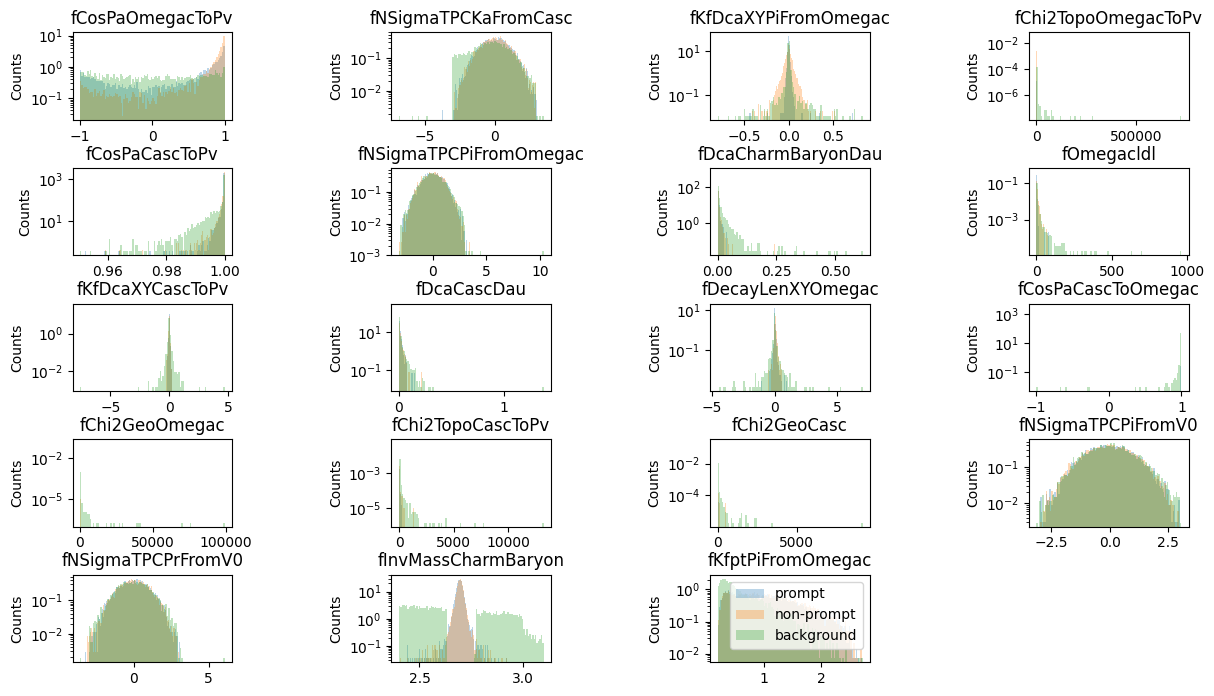

In [18]:
df_all = [df_prompt, df_non_prompt, df_background]
vars_to_draw = ['fCosPaOmegacToPv', 'fNSigmaTPCKaFromCasc', 'fKfDcaXYPiFromOmegac', 'fChi2TopoOmegacToPv', 
                'fCosPaCascToPv', 'fNSigmaTPCPiFromOmegac', 'fDcaCharmBaryonDau', 'fOmegacldl', 'fKfDcaXYCascToPv',
                'fDcaCascDau', 'fDecayLenXYOmegac', 'fCosPaCascToOmegac', 'fChi2GeoOmegac', 'fChi2TopoCascToPv',
                'fChi2GeoCasc', 'fNSigmaTPCPiFromV0', 'fNSigmaTPCPrFromV0',
                'fInvMassCharmBaryon', 'fKfptPiFromOmegac'] # Same variables as Yunfan's presentation 03/14/25
#vars_to_draw = ['fDcaCascDau', 'fDcaCharmBaryonDau', 'fDcaXYToPvV0Dau0', 'fDcaXYToPvV0Dau1', 
#                'fV0ldl', 'fCascldl', 'fCosPaV0ToPv',
#                'fInvMassCharmBaryon', 'fKfptPiFromOmegac'] # Same variables as in google slides.
leg_labels = ["prompt", "non-prompt", "background"] 

plot_utils.plot_distr(df_all, vars_to_draw, bins=100, labels=leg_labels, log=True, density=True, figsize=(12, 7), alpha=0.3, grid=False)
plt.subplots_adjust(left=0.06, bottom=0.06, right=0.99, top=0.96, hspace=0.55, wspace=1.0)
plt.savefig("/Users/fernandatorres/Desktop/Omegac_analysis/ML/pT2-4/Figures/distributions.png")
plt.show()

**Q**: Do the distributions look good? 

**Q**: Which features do you expect to have a larger impact on the BDT score? 

Similarly, the correlation matrix for the features is plotted with the function `plt_utils.plot_corr`.

It is important cross-check that none of the features is strongly related to the invariant mass to avoid biasing the measurement!

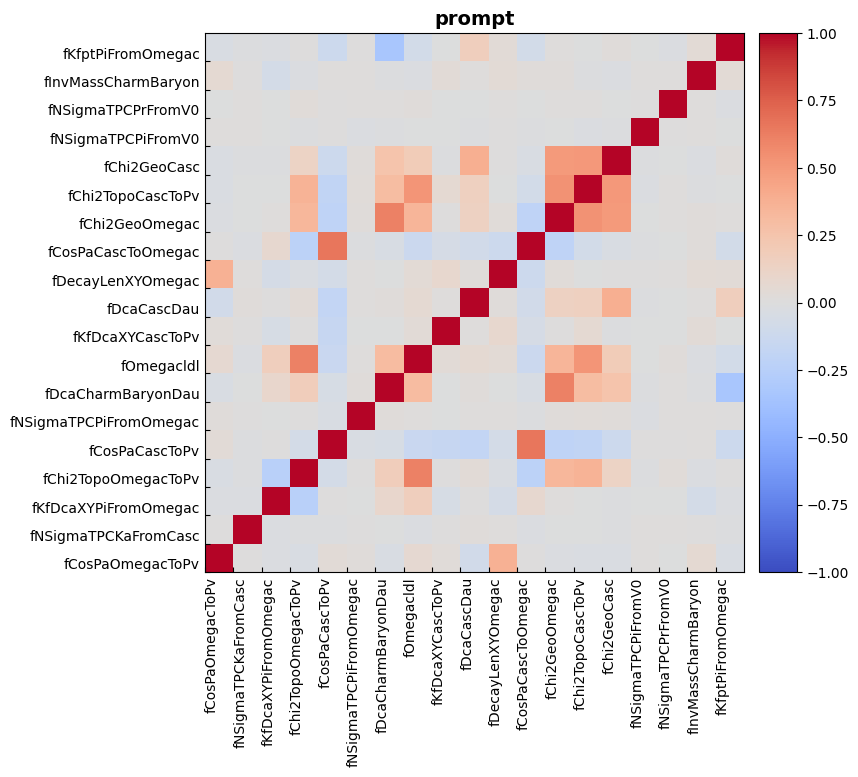

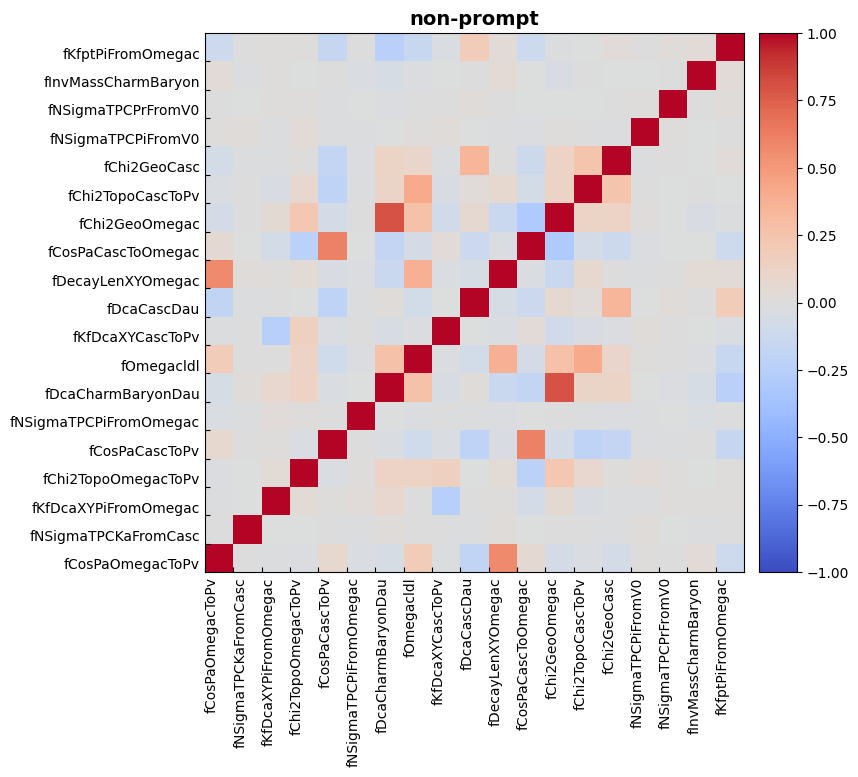

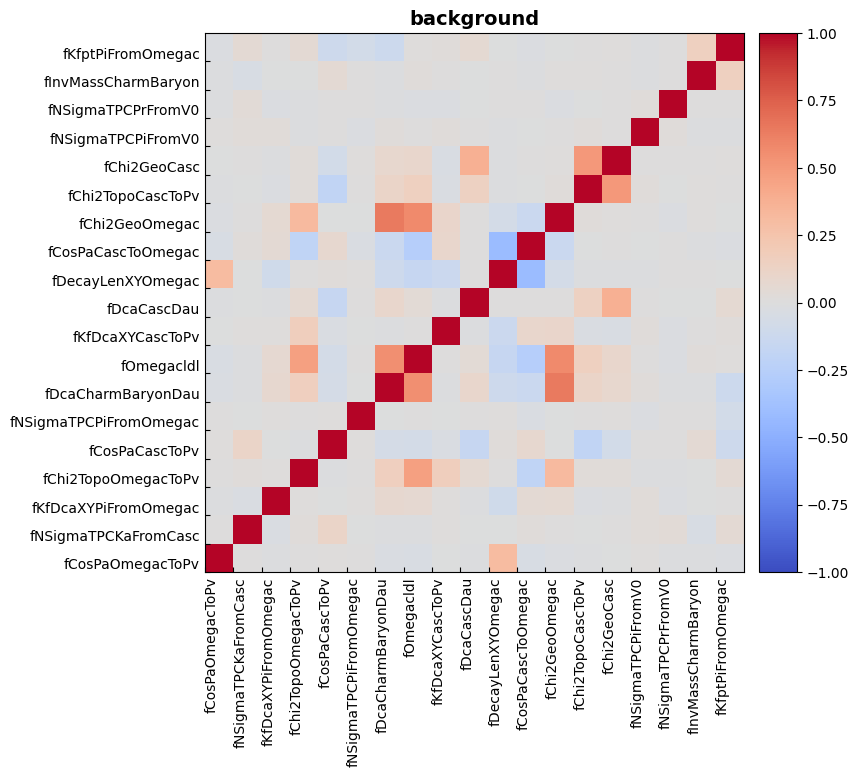

In [19]:
plot_utils.plot_corr(df_all, vars_to_draw, leg_labels)
plt.savefig("/Users/fernandatorres/Desktop/Omegac_analysis/ML/pT2-4/Figures/correlation_prompt.png")
plt.savefig("/Users/fernandatorres/Desktop/Omegac_analysis/ML/pT2-4/Figures/correlation_nonprompt.png")
plt.savefig("/Users/fernandatorres/Desktop/Omegac_analysis/ML/pT2-4/Figures/correlation_bkg.png")
plt.show()

**<font color='red'>_Feedback Time_: is everybody's code working?**</font>

A label is assigned to each candidate of the total set: _0_ for prompt $\mathrm{\Omega_c^0}$, _1_ for non-prompt $\mathrm{\Omega_c^0}$, and _2_ for background.

It is important to keep the same order in which the samples are considered also for the labels.

In order to train and test the BDT, the dataset is split into a _train set_ and a _test set_. The train set is used to train the BDT, while the test set is used to evaluate the performance of the trained BDT. It is important to have independent samples for training and testing to avoid biasing the evaluation of the BDT performance.

The fraction of the total set used as test set can be defined through the `test_size` parameter and is typically around 0.2 (20%). 

In [20]:
# Install scikit-learn
#%pip install scikit-learn

# Split each DataFrame into train and test sets
from sklearn.model_selection import train_test_split

# Assuming train_test_generator works like train_test_split
train_mc_prompt, test_mc_prompt = train_test_split(df_prompt, test_size=0.2, random_state=42)
train_mc_non_prompt, test_mc_non_prompt = train_test_split(df_non_prompt, test_size=0.2, random_state=42)
train_background, test_background = train_test_split(df_background, test_size=0.2, random_state=42)

# Create your train and test sets based on the split
train_all = [train_mc_prompt, train_mc_non_prompt, train_background]
test_all = [test_mc_prompt, test_mc_non_prompt, test_background]

The ouptut of the function `train_test_split` is a list containing the training and test sets, as well as the corresponding labels.
Let's split the training set, the test set, and the relative flags. 

In [21]:
train_features = pd.concat([train_all[0], train_all[1], train_all[2]])
train_labels = np.concatenate([np.zeros(len(train_all[0])), np.ones(len(train_all[1])), np.full(len(train_all[2]), 2)])
test_features = pd.concat([test_all[0], test_all[1], test_all[2]])
test_labels = np.concatenate([np.zeros(len(test_all[0])), np.ones(len(test_all[1])), np.full(len(test_all[2]), 2)])

### **The model**

For this tutorial, [_XGBoost_](https://xgboost.readthedocs.io/en/latest/) is used as classification algorithm. XGBoost implementation of the gradient boosted decision trees is designed to be highly efficient, flexible and portable. hipe4ml can deal with several implementations other than XGBoost models (e.g. LGBM or sklearn models). However, XGBoost models are usually employed in analyses of the heavy-flavour sector.

The _hipe4ml_ package interfaces with the model through the `ModelHandler` module. The `ModelHandler` is used to define the features used in the training process and to set the _hyperparameters_ of the model, such as the number of estimators, the maximum depth of the trees and the learning rate.

Hyperparameters are parameters that are not learned during the training process, but rather define the model’s architecture and the training process itself. Few of them are listed here below, for a complete description see the [_XGBoost-Doc_](https://xgboost.readthedocs.io/en/stable/parameter.html)
- `max_depth`: Maximum depth of a tree
- `learning_rate`: learning rate of the algorithm. It controls the step size of the gradient descent algorithm
- `n_estimators`: Number of decision trees in the BDT

Let's initialise the algorithm with the features we want to include in the training. **Remember**: exclude the mass and the $p_{\mathrm{T}}$ of the candidate!!! 


In [22]:
features_for_train = ['fCosPaOmegacToPv', 'fNSigmaTPCKaFromCasc', 'fKfDcaXYPiFromOmegac', 'fChi2TopoOmegacToPv', 
                      'fCosPaCascToPv', 'fNSigmaTPCPiFromOmegac', 'fDcaCharmBaryonDau', 'fOmegacldl', 'fKfDcaXYCascToPv',
                      'fDcaCascDau', 'fDecayLenXYOmegac', 'fCosPaCascToOmegac', 'fChi2GeoOmegac', 'fChi2TopoCascToPv',
                      'fChi2GeoCasc', 'fNSigmaTPCPiFromV0', 'fNSigmaTPCPrFromV0',
                      ] # Same variables as Yunfan's presentation 03/14/25
#features_for_train = [
#'fDcaCascDau', 'fDcaCharmBaryonDau', 'fDcaXYToPvV0Dau0', 'fDcaXYToPvV0Dau1',
#'fV0ldl', 'fCascldl', 'fCosPaV0ToPv'
#]  # Same as in google slides.
model_params = {
    'max_depth':5, 'learning_rate':0.029, 'n_estimators':500, 'min_child_weight':2.7,
    'subsample':0.90, 'colsample_bytree':0.97, 'n_jobs':1, 'tree_method': 'hist'
}

model_clf = xgb.XGBClassifier()
model_hdl = ModelHandler(model_clf, features_for_train, model_params)

A huge number of features would lead to a large time and CPU consumption. For this reason, we decided to limit the number of variables in the training.

### **Training and testing the model**
The model training is performed with the method `train_test_model` of the `ModelHandler` module. 
It requires as arguments:
- A list containing: 
    1. The training set
    2. The true class label for the training set
    3. The test set
    4. The true class label for the test set
- The `multi_class_opt` option

The multi-class option can be set to `ovo` (i.e., _One Vs One_) or `ovr` (i.e., _One Vs Rest_). It is used to define the behaviour of a metric called ROC AUC (_Area Under the Curve_ of the _Receiver Operating Characteristic_), which is used to evaluate the performance of the classifier. You can find more information in the addendum at the end of the tutorial.

In [23]:
model_hdl.train_test_model((train_features, train_labels, test_features, test_labels), multi_class_opt="ovo")

# the same result can be obtained by splitting the training and test process with the functions below:
# model_hdl.fit(trainset, ytrain, multi_class_opt="ovo")
# model_hdl.predict(testset, ytestset, multi_class_opt="ovo")

Training xgboost model for classification
Number of detected classes: 3
Training the model: ...
Training the model: Done!
Testing the model: ...
ROC_AUC_score: 0.843789
Testing the model: Done!


**Q:** How do you apply the BDT to the training and test sets?

**Q:** How do you expect the BDT score distributions to be in the training and test sets?

The predictions for the training and the test sets are obtained with the `predict` method which has two arguments:
- the data you want to apply the model to
- `output_margin`, a boolean indicating if we want the raw BDT output (True) or transform it with a [softmax](https://en.wikipedia.org/wiki/Softmax_function) function (False).
The _softmax_ function is used to transform the raw BDT output into a probability distribution (i.e., normalising the scores between 0 and 1).

For this session we use probabilities!

In [24]:
y_pred_train = model_hdl.predict(train_features, output_margin=False)
y_pred_test =  model_hdl.predict(test_features, output_margin=False)

The results of the training process can be observed by plotting the distributions of the BDT scores for the training and the test sets. The output consists of three scores, related to the probability of belonging to each of the classes (prompt, non-prompt, and background) used for the training. This operation is performed with the method `plot_utils.plot_output_train_test`.

In [25]:
y_pred_train_class = np.argmax(y_pred_train, axis=1)
y_pred_test_class = np.argmax(y_pred_test, axis=1)

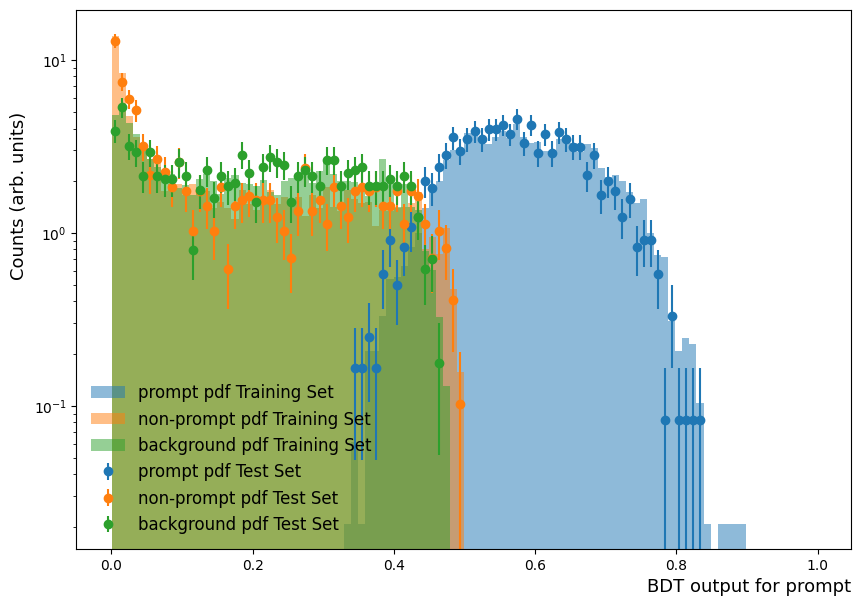

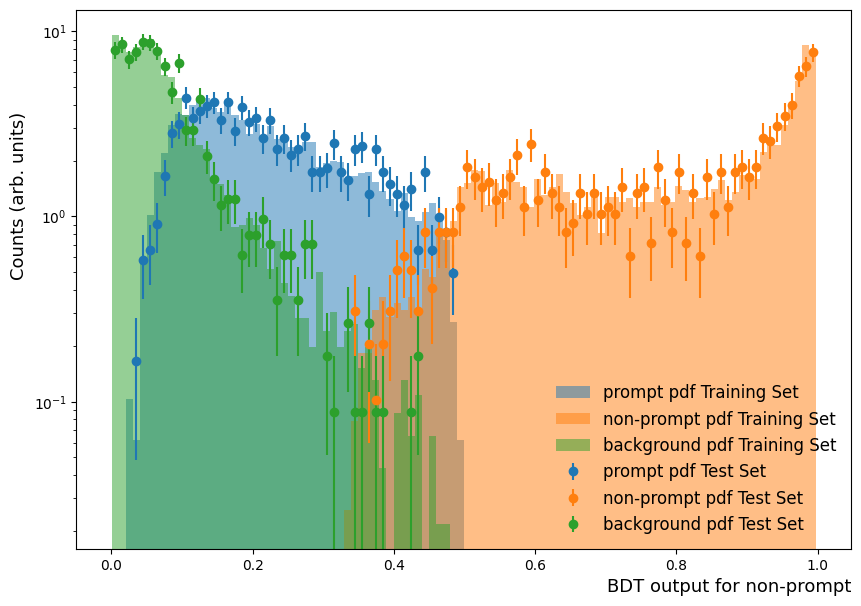

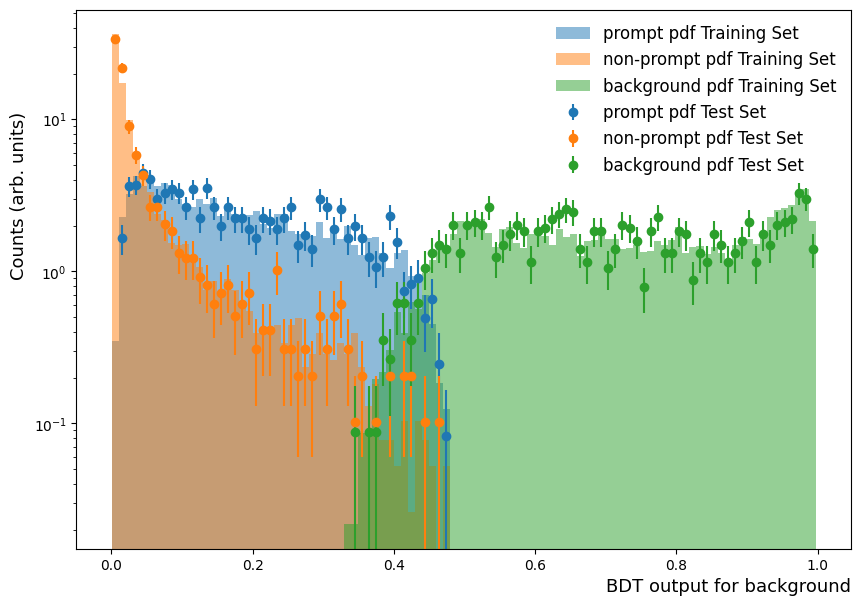

In [26]:
ml_out_fig = plot_utils.plot_output_train_test(model_hdl, [train_features, y_pred_train_class, test_features, y_pred_test_class], bins=100, 
                                               output_margin=False, labels=leg_labels,
                                               logscale=True, density=True)
plt.savefig("/Users/fernandatorres/Desktop/Omegac_analysis/ML/pT2-4/Figures/output_prompt.png")
plt.savefig("/Users/fernandatorres/Desktop/Omegac_analysis/ML/pT2-4/Figures/output_nonprompt.png")
plt.savefig("/Users/fernandatorres/Desktop/Omegac_analysis/ML/pT2-4/Figures/output_bkg.png")
plt.show() 

What can we say about the distributions of the BDT scores?
- For each class, the distribution of the BDT scores related to the probability of belonging to that class peaks at high values (i.e., close to 1).
- For each class, the distributions of the BDT scores related to the probability of belonging to the other classes peak at low values (i.e., close to 0).
- The distributions of the model scores obtained from the test set are in good agreement with those obtained from the training set. This is a sign that the model is not significantly affected by overfitting.

We have a good performing model!

### **Feature Importance**

One of the most important (and very interesting) topic in ML is the interpretation of the models output. To understand how a model makes its decisions, the feature importance can be studied. This allows the understanding of which features are more important for the model’s decision-making process, and the optimisation of the feature selection. In addition, the feature importance can be used to check whether the model is learning on the correct features in terms of the physics of the problem.

The feature importance implemented in the [`SHAP`](https://shap.readthedocs.io/en/latest/index.html) library is used in this hands-on session. An importance value is assigned to each feature, representing the effect on the model prediction of including that feature. The higher the value, the more important the feature is for the model.

**Q**: Which features do you expect to weight more?

The SHAP feature importance can be plotted with the method `plot_utils.plot_feat_imp`.

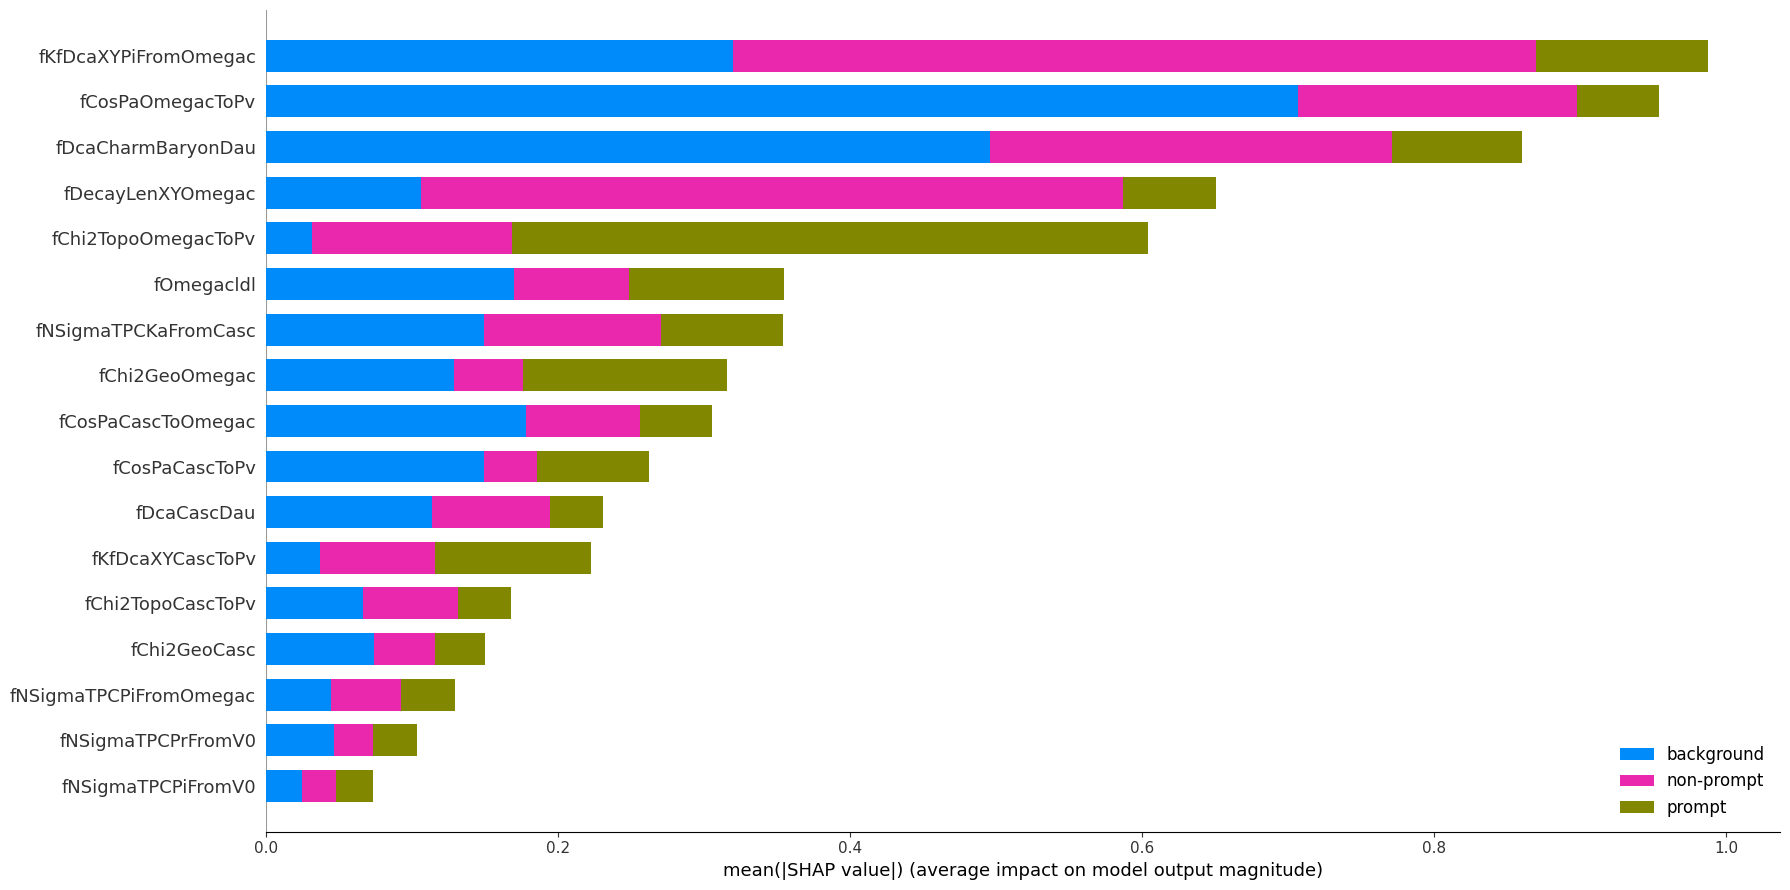

In [27]:
shap_figs = plot_utils.plot_feature_imp(test_features, test_labels, model_hdl, labels=leg_labels)  

# only show the SHAP summary plot
plt.close(shap_figs[0])
plt.close(shap_figs[1])
plt.close(shap_figs[2])

plt.savefig("/Users/fernandatorres/Desktop/Omegac_analysis/ML/pT2-4/Figures/feature_importance.png")
plt.show()  

### **Store the trained model**
Once trained and tested, the model can be saved locally.

The model handler from hipe4ml can be saved with the `ModelHandler.dump_model_handler` function. We can then retrieve the model handler for other applications with the `ModelHandler.load_model_handler` function.

The XGBoost model can be saved with the `ModelHandler.dump_original_model` function.

In [28]:
model_hdl.dump_model_handler("./pT2-4/ModelHandler_files/ModelHandler_MulticlassOmegac_pT_2_4.pickle")
model_hdl.dump_original_model("./pT2-4/XGBoost_files/XGBoostModel_MulticlassOmegac_pT_2_4.pickle")

### **Convert the model in ONNX format**
To be applied on the Grid, the XGBoost model has to be converted in ONNX format.

This can be done with the `hipe4ml_converter` package.

In [29]:
#%pip install --upgrade pip setuptools wheel
#%pip install Levenshtein
#%pip install pyarrow
#%pip install python-Levenshtein
#%pip show pyarrow Levenshtein

In [30]:
%pip install hipe4ml_converter
%pip install dask[dataframe]

Note: you may need to restart the kernel to use updated packages.
zsh:1: no matches found: dask[dataframe]
Note: you may need to restart the kernel to use updated packages.


In [31]:
from hipe4ml_converter.h4ml_converter import H4MLConverter

model_converter = H4MLConverter(model_hdl) # create the converter object
#model_onnx = model_converter.convert_model_onnx(1, len(features_for_train))
model_onnx = model_converter.convert_model_onnx(1)
model_converter.dump_model_onnx("./pT2-4/onnx_files/model_onnx_2.onnx") # dump the model in ONNX format

/opt/homebrew/lib/python3.11/site-packages/dask/dataframe/__init__.py:49: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)
Importing plotly failed. Interactive plots will not work.


File ./pT2-4/onnx_files/model_onnx_2.onnx saved


**<font color='red'>_Feedback Time_: the models have been saved for everyone?**</font>


### **Apply the model on the dataset we want to analyse!**
Your turn now! Remember that you have downloaded a file called `background_output.root` in the `data` folder. This file contains the dataset you want to analyse. You should now load the file with `uproot` and apply the model you have just trained on it. You can call the output of the prediction `y_pred`.


In [32]:
hdl_data_appl = uproot.open("data/background_output.root")["O2hfkfomegacfull"]
df_data_appl = hdl_data_appl.arrays(library="pd")
df_data_appl = df_data_appl.query("2 < fKfptOmegac < 4")

# apply the model here!
y_pred = model_hdl.predict(df_data_appl[features_for_train], output_margin=False) 

Now, we will add the BDT score to the dataset we want to analyse, and plot the BDT score distributions for the prompt, non-prompt, and background classes.

Add new columns with the BDT scores with the following code.

In [33]:
df_data_appl['prompt_score'] = y_pred[:, 0] # prompt
df_data_appl['non-prompt_score'] = y_pred[:, 1] # non-prompt
df_data_appl['background_score'] = y_pred[:, 2] # background

In [34]:
df_data_appl

,index,fNSigmaTPCPiFromOmegac,fNSigmaTOFPiFromOmegac,fNSigmaTPCKaFromCasc,fNSigmaTOFKaFromCasc,fNSigmaTPCPiFromV0,fNSigmaTPCPrFromV0,fKfDcaXYPiFromOmegac,fDcaCascDau,fDcaCharmBaryonDau,...,fOmegacChi2OverNdf,fMassV0Chi2OverNdf,fMassCascChi2OverNdf,fCascRejectInvmass,fFlagMcMatchRec,fOriginRec,fCollisionMatched,prompt_score,non-prompt_score,background_score
0,0,-1.975508,-1.210315,2.271587,207.755219,1.412282,-1.118072,0.001186,0.018412,0.002257,...,2.951252,2.933510,3.769569,1.461094,-7,0,False,0.506066,0.048060,0.445874
2,2,0.122832,-999.000000,-1.085909,703.819092,0.211596,1.619161,-0.009373,0.008729,0.000582,...,0.025051,16.619719,3.087469,1.505481,-7,0,False,0.184983,0.261984,0.553033
3,3,0.971091,-999.000000,-1.085909,703.819092,0.211596,1.619161,-0.006717,0.008729,0.010313,...,5.283413,16.619719,3.087469,1.505481,-7,0,False,0.200243,0.080108,0.719648
7,7,-0.786808,56.676842,2.198135,80.004707,-0.075251,-0.531225,0.003337,0.001893,0.001031,...,1.414544,2.552037,3.960181,1.436921,-7,0,False,0.215323,0.044206,0.740471
9,9,0.663533,-999.000000,2.198135,80.004707,-0.075251,-0.531225,-0.000735,0.001893,0.001103,...,0.831429,2.552037,3.960181,1.436921,-7,0,False,0.255045,0.061212,0.683743
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
459212,459212,1.582214,-999.000000,-2.221141,70.895981,-0.217076,-0.225649,0.002418,0.016721,0.004421,...,3.896929,4.582462,17.096607,1.328313,-7,0,False,0.168177,0.026944,0.804879
459213,459213,0.051602,-999.000000,-2.221141,70.895981,-0.217076,-0.225649,-0.001541,0.016721,0.001012,...,0.291890,4.582462,17.096607,1.328313,-7,0,False,0.282794,0.051032,0.666173
459216,459216,-1.097610,-999.000000,-2.569334,-17.898993,-1.412639,2.415205,0.001144,0.017526,0.024851,...,55.204292,125.311737,27.331125,1.349094,-7,0,False,0.007843,0.004568,0.987589
459217,459217,1.795360,0.412122,-0.815953,-5.756090,-0.309488,0.218615,-0.004387,0.002850,0.001835,...,1.131990,44.741219,14.070221,1.420641,-7,0,False,0.184062,0.200351,0.615588


We can now plot the distributions of the BDT scores for the prompt, non-prompt, and background classes.

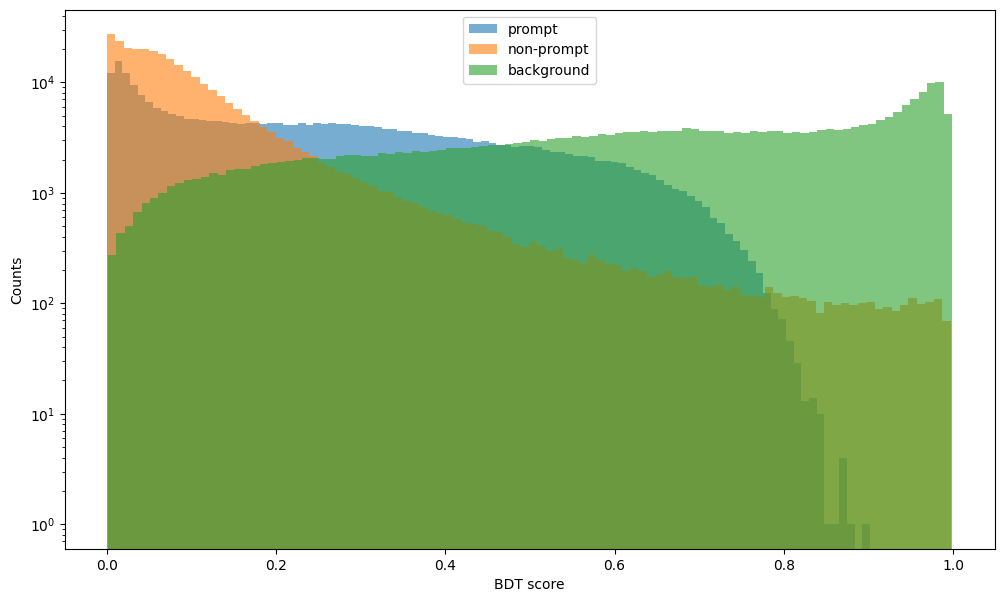

In [35]:
df_data_appl['prompt_score'].plot(kind='hist', bins=100, alpha=0.6, log=True, figsize=(12, 7), grid=False, label='prompt')
df_data_appl['non-prompt_score'].plot(kind='hist', bins=100, alpha=0.6, log=True, figsize=(12, 7), grid=False, label='non-prompt')
df_data_appl['background_score'].plot(kind='hist', bins=100, alpha=0.6, log=True, figsize=(12, 7), grid=False, label='background')
plt.xlabel('BDT score')
plt.ylabel('Counts')
plt.legend()

plt.savefig("/Users/fernandatorres/Desktop/Omegac_analysis/ML/pT2-4/Figures/BDTscore.png")
plt.show()

What can we see?

The BDT score distributions for the prompt and non-prompt classes peak at low values, while the BDT score distribution for the background class peaks at high values. We are therefore in presence of a data sample with a lot of background candidates.

(You should consider that this plot shows the distributions of the probabilities of the candidates to belong to the prompt, non-prompt, and background classes, for a **single** dataset. It is different from the similar plot we made before, which showed the distributions of the probabilities of candidates from the **three classes** to belong to **a single** class.)

### **Choose your selections!**
Almost there! We can now apply some selections to the dataset. To do so, you can use the `query` method of pandas.DataFrame, which takes as argument a string containing the selection you want to apply.

Q: What kind of selections would you apply to the dataset?

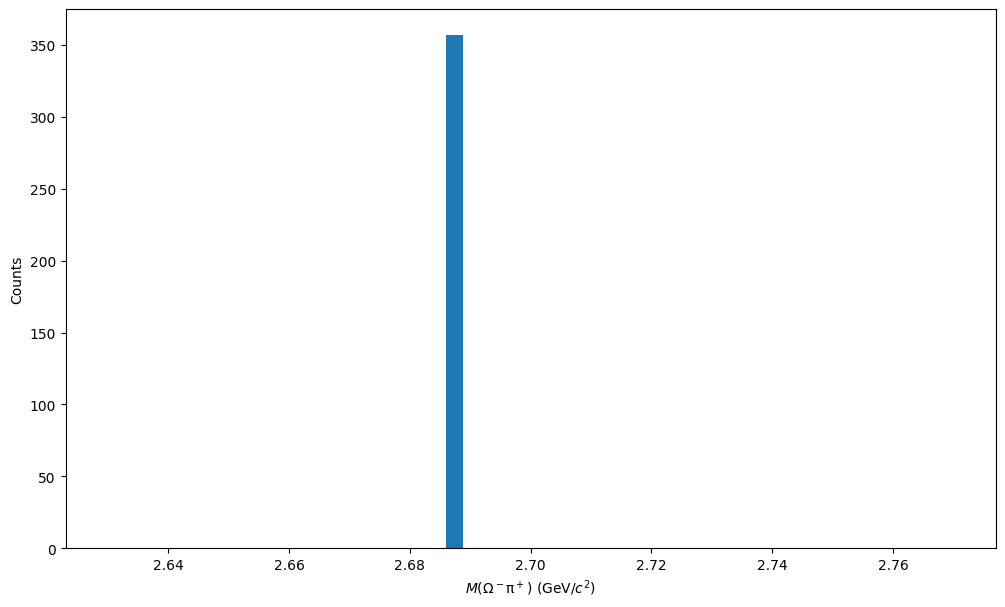

In [36]:
selections = 'prompt_score > 0.43 and background_score < 0.014'
df_sel = df_data_appl.query(selections)
hist = df_sel.hist(column='fInvMassCharmBaryon', bins=50, range=(2.63, 2.77), figsize=(12, 7), grid=False, density=True)
plt.xlabel(r'$M(\mathrm{\Omega^-\pi^+})$ (GeV/$c^2$)')
plt.ylabel('Counts')
plt.title('')
plt.show()

Congratulations! You have observed a $\mathrm{\Omega^{0}_{c}}$ baryon signal!

### Efficiency evaluation

When applying a selection to the dataset, we typically reject a fraction of the signal candidates. Therefore, it is important to evaluate the efficiency of the selection. The efficiency is defined as the fraction of signal candidates that pass the selection.

It is very important, in order not to bias the efficiency evaluation, not to evaluate the efficiency on the same dataset used to train the model. This is because the model has already seen the candidates in the training set and has learned from them. Therefore, the efficiency evaluation should be performed on an independent dataset.

We can use the test set for this purpose. Firstly, let's retrieve the prompt and non-prompt candidates from the test set.

In [37]:
test_features_prompt = test_features[test_labels == 0] # test_labels == 0 is an array of booleans ([True, False, False, ...]), which is used to select the rows of the DataFrame
test_features_nonprompt = test_features[test_labels == 1 ]# test_labels == 1 is an array of booleans ([True, False, False, ...]), which is used to select the rows of the DataFrame

test_scores_prompt = y_pred_test[test_labels == 0]
test_scores_nonprompt = y_pred_test[test_labels == 1]

test_features_prompt['prompt_score'] = test_scores_prompt[:, 0] # prompt
test_features_prompt['nonprompt_score'] = test_scores_prompt[:, 1] # non-prompt
test_features_prompt['background_score'] = test_scores_prompt[:, 2] # background

test_features_nonprompt['prompt_score'] = test_scores_nonprompt[:, 0] # prompt
test_features_nonprompt['nonprompt_score'] = test_scores_nonprompt[:, 1] # non-prompt
test_features_nonprompt['background_score'] = test_scores_nonprompt[:, 2] # background

Now, we can apply the selection to the test set and evaluate the efficiency. You can try by yourself to apply the selection to the test set and evaluate the efficiency.

Keep in mind that `test_features_prompt` and `test_features_nonprompt` are `pandas.DataFrame`s (which you used before).

You can retrieve the number of entries in a `pandas.DataFrame` with the `len` function.

In [38]:
sel_df_prompt = test_features_prompt.query(selections)
sel_df_nonprompt = test_features_nonprompt.query(selections)

# Your turn! You can evaluate the number of entries of the pandas.DataFrame named df using len(df)
eff_prompt = len(sel_df_prompt)/len(test_features_prompt)
eff_nonprompt = len(sel_df_nonprompt)/len(test_features_nonprompt)

print("Prompt efficiency: ", eff_prompt)
print("Nonprompt efficiency: ", eff_nonprompt)

Prompt efficiency:  0.0045045045045045045
Nonprompt efficiency:  0.005405405405405406


We can also study how the efficiency changes with the selection on the prompt BDT score. We can plot the efficiency as a function of the BDT score.

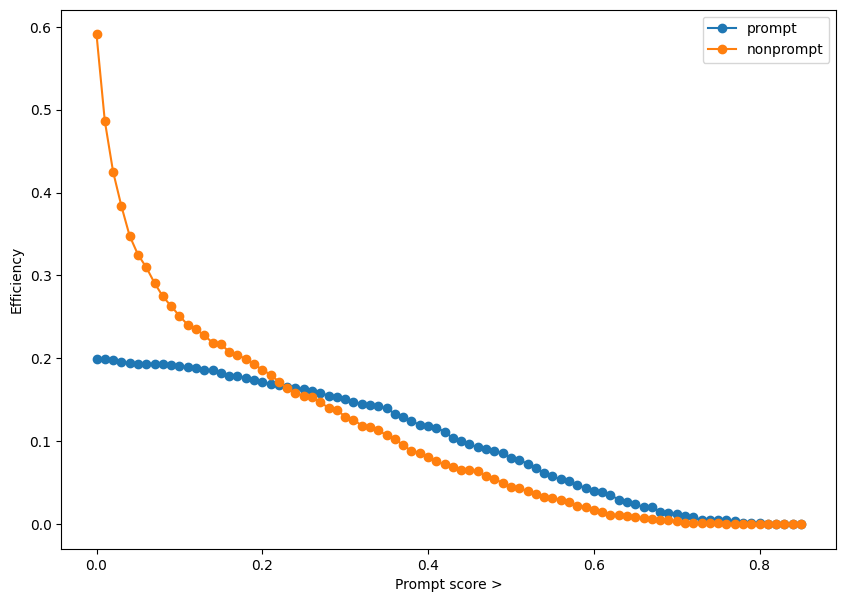

In [39]:
prompt_scores = np.linspace(0.0, 0.85, 86) # [0.00, 0.01, 0.02, ..., 0.85]
efficiencies_prompt = [] # list to store the efficiencies (similar to an std::vector in C++)
efficiencies_non_prompt = [] # list to store the efficiencies (similar to an std::vector in C++)

# loop over the prompt_scores
for score in prompt_scores:
    selections = f'prompt_score > {score} and background_score < 0.05'
    sel_df_prompt = test_features_prompt.query(selections)
    efficiencies_prompt.append(len(sel_df_prompt) / len(test_features_prompt)) # similar to push_back in C++
    sel_df_non_prompt = test_features_nonprompt.query(selections)
    efficiencies_non_prompt.append(len(sel_df_non_prompt) / len(test_features_nonprompt)) # similar to push_back in C++

plt.plot(prompt_scores, efficiencies_prompt, label='prompt', marker='o')
plt.plot(prompt_scores, efficiencies_non_prompt, label='nonprompt', marker='o')
plt.xlabel('Prompt score >')
plt.ylabel('Efficiency')
plt.legend()
plt.show()

As you can see, the selection on the prompt score does a very good job in rejecting non-prompt candidates. The efficiency is very high for prompt candidates, while it is very low for non-prompt candidates.

At very high threshold values, the efficiency for prompt candidates steeply decreases. For your future analyses, a key point will be to find a working point providing the best compromise between signal efficiency and background rejection. 

# **BEFORE THE COFFEE BREAK!!!** 

Don't forget to download the AO2D file necessary for the next step of the tutorial! You can do this (**on your laptop**) as
```bash
curl -L https://cernbox.cern.ch/s/uIR0aumtfT14NIm/download --output AO2D_MC_Ds.root
```
It will take some time to complete.

# **Addenda**

### **Optimisation of hyperparameters with Optuna**

The optimisation of the hyperparameters is a key step to obtain the best performance from the algorithm. In _hipe4ml_ the [`Optuna`](https://github.com/optuna/optuna) package is employed for the optimisation through the method `ModelHandler.optimize_params_optuna`.

The difference between Optuna and other packages dedicated to hyperparameters optimisation based on grid search or random search is that Optuna takes into account the past hyperparameter configuration evaluations when choosing the configuration to evaluate next. (More info about Optuna can be found [here](https://arxiv.org/abs/1907.10902)).

A set of hyperparameters should be tested on different sample than the one used for the training and testing, called _validation sample_, to avoid overfitting problems. Since the number of events is limited, an approach called _k-fold cross validation_ is used. 

In the cross validation procedure, the original sample is divided in _k_ parts called _folds_. For each set of hyperparameters, _n-1_ folds are used for the optimisation and the remaining one as validation. This operation is repeated after permuting the folds used for optimisation and for testing and the final result is the mean value of all the permutations. The hyperparameters that give the best performance are then used for the training.

The _ModelHandler_ automatically updates the hyperparameters after their optimisation.

To spare time, in this tutorial the hyperparameter optimisation and the number of configuration was limited.

The optimised configuration can be saved and loaded afterwards. Let's have a look!

<img src="img/k_fold.png" 
     align="center" 
     width="900" />

You can try to optimise the BDT yourself with Optuna with the following commands.

Remember to set the range in which you want to optimise the hyperparameters, the metric you want to optimise, if you want to maximise or minimise it, and the number of trials you want to try.

[I 2025-04-04 11:58:32,713] A new study created in memory with name: no-name-9b5740ec-9612-4c7e-9173-ceec13a5b11e
/opt/homebrew/lib/python3.11/site-packages/hipe4ml/model_handler.py:389: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  params[key] = trial.suggest_uniform(
[I 2025-04-04 11:58:38,572] Trial 0 finished with value: 0.8446542200161711 and parameters: {'max_depth': 2, 'learning_rate': 0.06489445119687427}. Best is trial 0 with value: 0.8446542200161711.
/opt/homebrew/lib/python3.11/site-packages/hipe4ml/model_handler.py:389: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  params[key] = trial.suggest_uniform(
[I 2025-04-04 11:58:38,682] Trial 5 finished with value: 0.8348832532570716 and parameters: 

Number of finished trials: 10
Best trial:
Value: 0.8474769023301783
Params: 
    max_depth: 4
    learning_rate: 0.023380294883859308


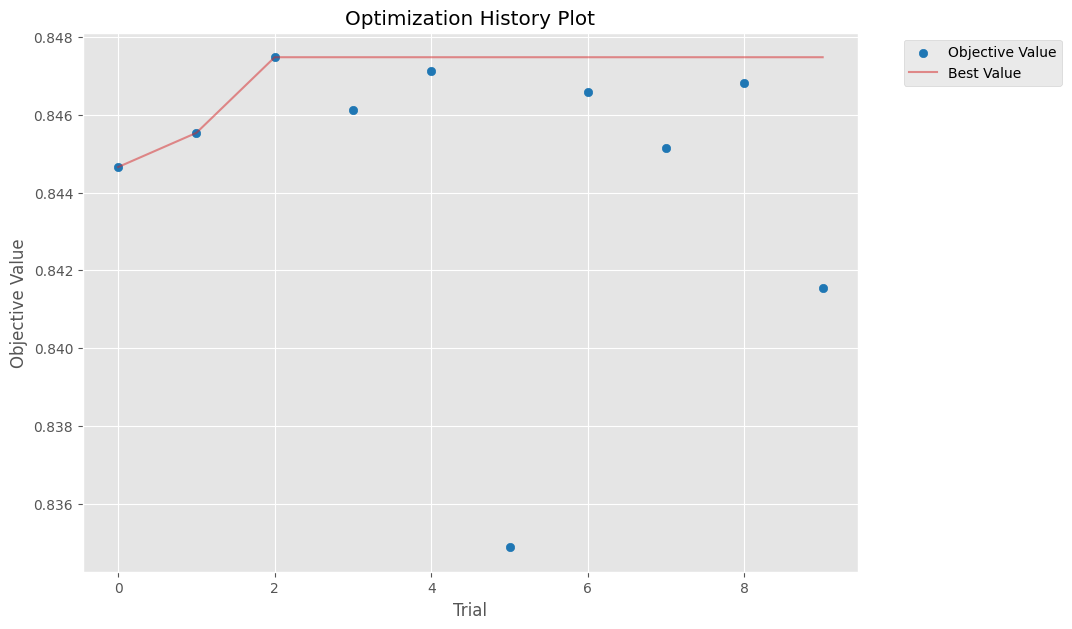

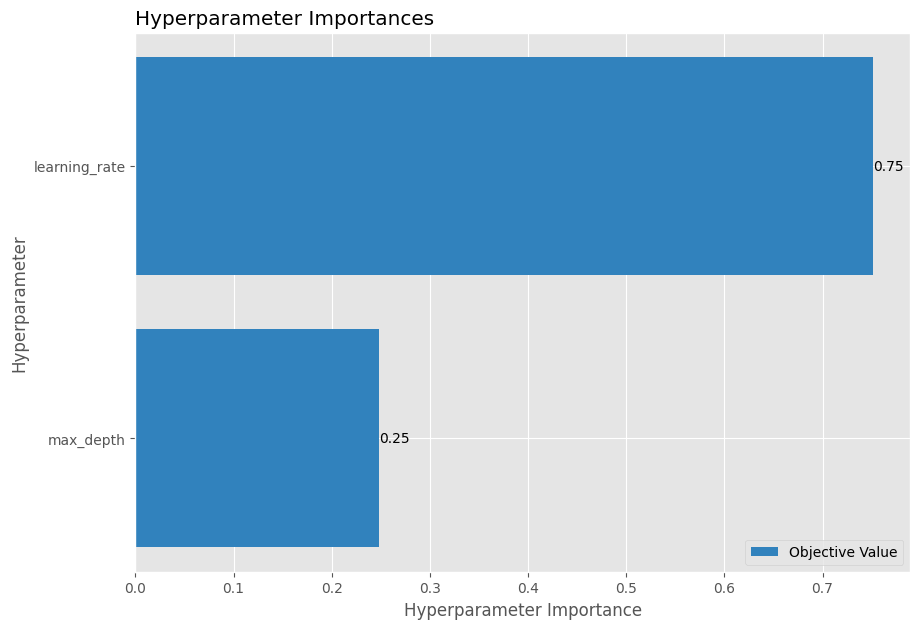

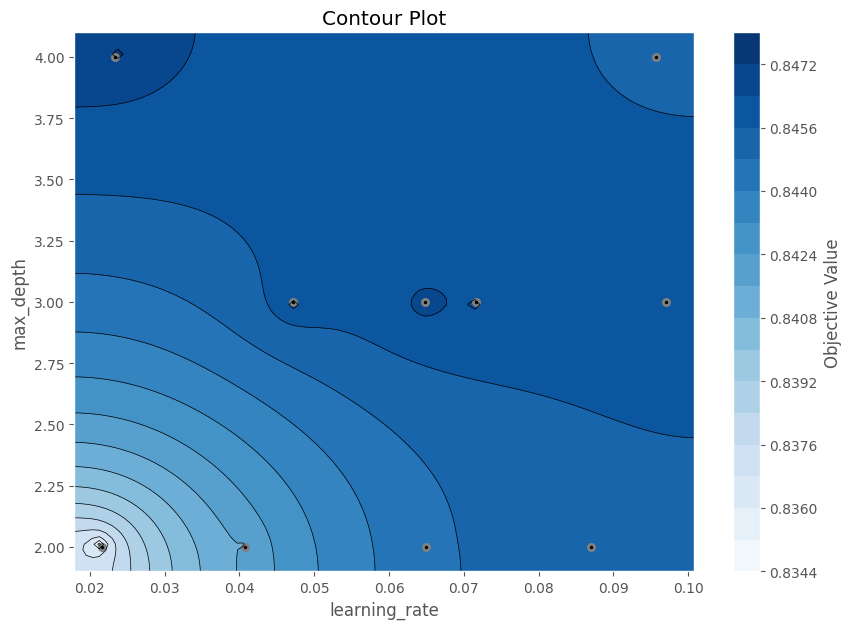

In [40]:
import optuna as op
import pickle

hyper_pars_ranges = {"max_depth": (2, 4), "learning_rate": (0.01, 0.1)}
train_test_data = (train_features, train_labels, test_features, test_labels)

opstudy = model_hdl.optimize_params_optuna(
    train_test_data, hyper_pars_ranges, cross_val_scoring="roc_auc_ovo", n_jobs=8,
    n_trials=10, direction="maximize", save_study='pT2-4/Optuna_files/optuna_study_2.pkl'
)
fig = op.visualization.matplotlib.plot_optimization_history(opstudy) 
fig = op.visualization.matplotlib.plot_param_importances(opstudy)
fig = op.visualization.matplotlib.plot_contour(opstudy)
plt.show()

### **Receiver Operating Curve**
The quality of the algorithm can be also studied with the _Receiver Operating Characteristic_ (_ROC_) curve. The ROC curve which represents the true positive rate (TPR) against the false positive rate (FPR) for different thresholds on the BDT ouptut values. TPR and FPR are defined as:

$\mathrm{TPR}=\frac{\sum \mathrm{TP}}{\sum \mathrm{TP} + \sum \mathrm{FN}} \hspace{2cm} \mathrm{FPR}=\frac{\sum \mathrm{FP}}{\sum \mathrm{FP} + \sum \mathrm{TN}} $

The true positives (TP) are the number of correctly classified positive candidates, the false positives (FP) are the number of negative candidates being mistakenly classified as positives, and the true negatives (TN) and false negatives (FN) are defined similarly.

In the case of multi-classifiaction problems, the ROC curve is not natively defined. Hence, we can generalise it by either employing the _One Vs One_ or the _One Vs Rest_ approach. In this tutorial, we adopt the _One Vs One_, which is a plot of the TPR against the FPR for a given pair of classes. For a classification problem with $N$ classes, there are $N(N − 1)$ possible pairs of ordered classes, and therefore of _One Vs One_ ROC curves.

The most common way employed to evaluate the performance of a BDT is to compute the _Area Under the Curve_ ROC, called AUC. The ROC AUC ranges from 0 to 1. A random classifier has a ROC AUC of 0.5, while a perfect classifier has a ROC AUC of 1.

A good model classifier is characterised by a large area under the ROC curve (_ROC AUC_).

**Q**: How do you expect the ROC Curve to be?

**Q**: How do you expect the ROC AUC to be?

**Q**: Do you expect any difference between training and test? 


The ROC curve can be plotted with the method `plot_utils.plot_roc_train_test`. 

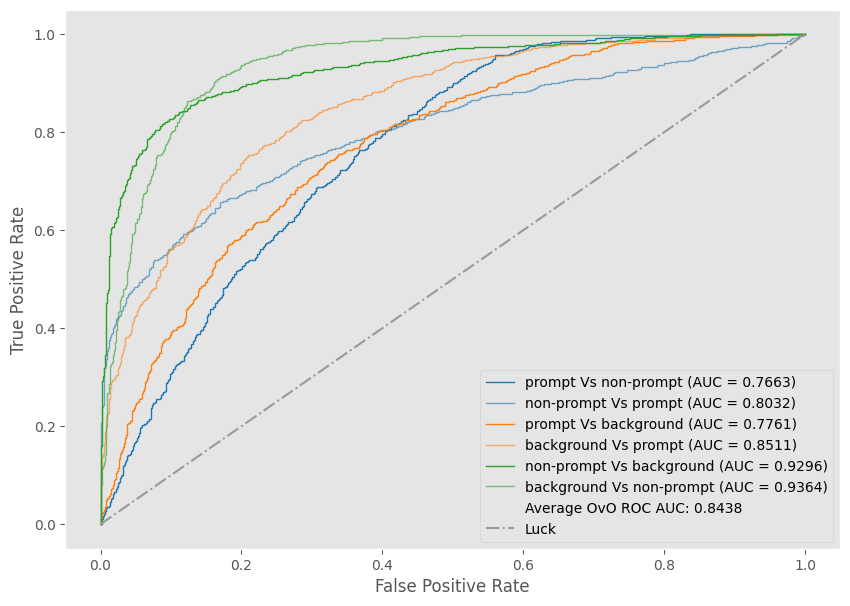

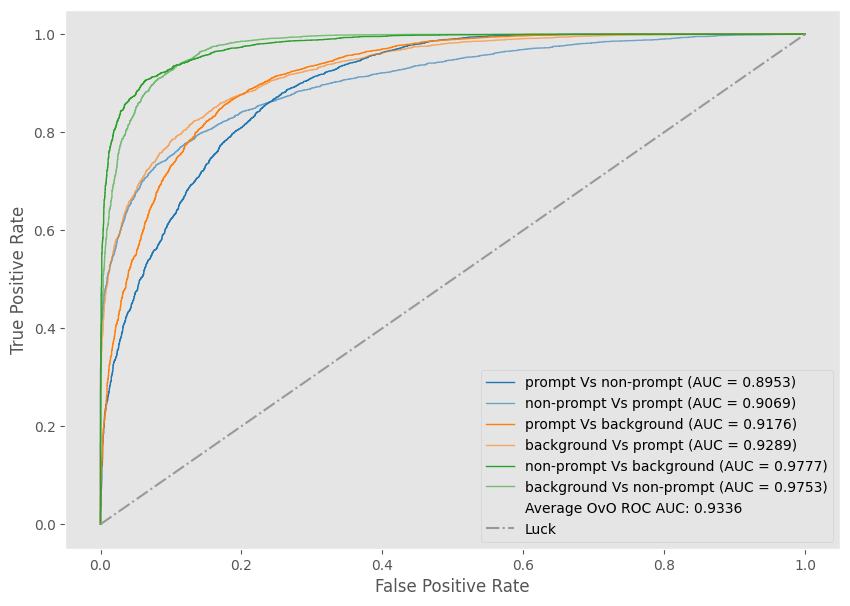

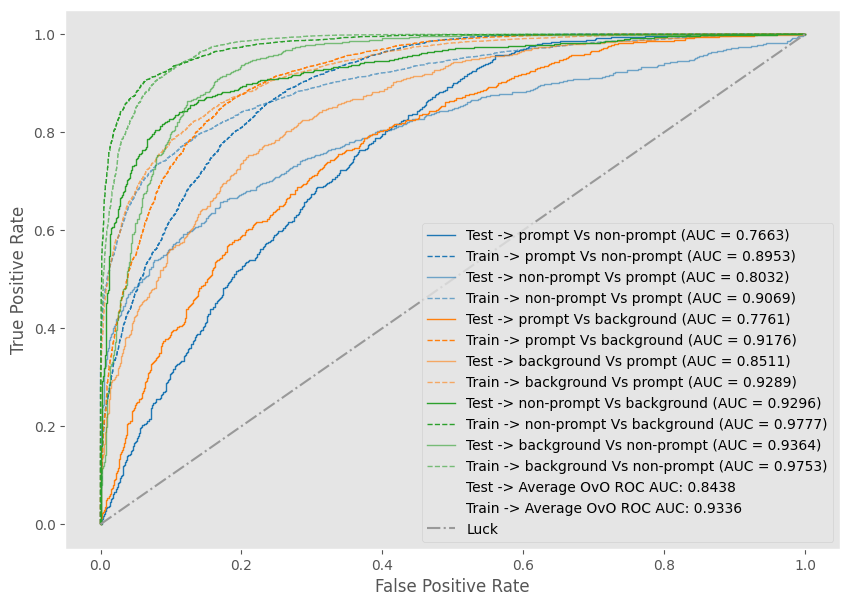

In [ ]:
# this will produce 3 plots: the ROC curves for the training and test sets, and the a comparison of the two
roc_train_test_fig = plot_utils.plot_roc_train_test(train_test_data[3], y_pred_test, train_test_data[1], y_pred_train, None, leg_labels, multi_class_opt="ovo")

#plt.savefig("/Users/fernandatorres/Desktop/Omegac_analysis/ML/pT2-4/Figures/ROCAUC_test.png")
#plt.savefig("/Users/fernandatorres/Desktop/Omegac_analysis/ML/pT2-4/Figures/ROCAUC_training.png")
#plt.savefig("/Users/fernandatorres/Desktop/Omegac_analysis/ML/pT2-4/Figures/ROCAUC_both.png")
plt.show()

In [42]:
import inspect
print(inspect.getsource(plot_utils.plot_roc_train_test))


def plot_roc_train_test(y_truth_test, y_score_test, y_truth_train, y_score_train, pos_label=None, labels=None,
                        average='macro', multi_class_opt='raise'):
    """
    Calculate and plot the roc curve for test and train sets

    Parameters
    -------------------------------------
    y_truth_test: array
        True labels for the belonging class of the test set. If labels
        are not {0, 1} in binary classification, then pos_label should
        be explicitly given. In multi-classification labels must be
        {0, 1, ..., N}

    y_score_test: array
        Target scores for the test set, can either be probability
        estimates or non-thresholded measure of decisions (as returned
        by “decision_function” on some classifiers).

    y_truth_train: array
        True labels for the belonging class of the train set. If labels
        are not {0, 1} in binary classification, then pos_label should
        be explicitly given. In multi-classification l

For a binary classification task (only 2 classes involved) the output of the ML model is a single value ranging from 0 to 1, and can be interpreted as the probability of the candidate belonging to the positive class. If positive candidates are selected as those with a score greater than a certain threshold $t$, when $t = 0$ all candidates are classified as positive, and both the TPR and FPR will be equal to 1. On the other hand, if $t = 1$, no candidate is classified as positive, and the TPR and FPR will both equal 0. Therefore, the different values of $t$ between 0 and 1, which yield different TPR and FPR values, will trace the ROC curve, going from the point (1,1) to (0,0) as $t$ increases.

Evaluating the ROC AUC in training and test a slight difference is found. The higher ROC AUC in training compared to test is a systematic behaviour due to the small presence of overfitting, which indicates a successful training.

### **References**
- [Deep Learning and Its Application to LHC Physics](https://arxiv.org/pdf/1806.11484.pdf)
- [Machine learning at the energy and intensity frontiers of particle physics](https://www.nature.com/articles/s41586-018-0361-2)
- [HEP ML Living Review](https://github.com/iml-wg/HEPML-LivingReview)
- [Inter-Experimental LHC Machine Learning Working Group](https://github.com/iml-wg)

Remember to follow the [ALICE ML meetings](https://indico.cern.ch/category/7570/) for many more inputs and applications of ML techniques!
Contact [Francesco](francesco.mazzaschi@cern.ch) and [Fabio](fabio.catalano@cern.ch) for any questions ;)